<a href="https://colab.research.google.com/github/skumbham/Chicago-Crime-Weather-Analysis/blob/main/BDA_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9ad50fe596dcda4782b8730204bbf57a78da21249096bfda5cb30d23ffe61ae2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# Libraries Required

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import to_date

# Loading the Datasets

In [4]:
spark = SparkSession.builder.appName("ChicagoCrimeWeatherAnalysis").getOrCreate()

In [6]:
weather_df = spark.read.csv('/content/drive/MyDrive/ChicagoWeatherDataset.csv', header=True, inferSchema=True)
crime_df = spark.read.csv('/content/drive/MyDrive/ChicagoCrimeDataset.csv', header=True, inferSchema=True)


In [7]:
weather_df.printSchema()
crime_df.printSchema()
weather_df.show(5)
crime_df.show(5)


root
 |-- name: string (nullable = true)
 |-- datetime: date (nullable = true)
 |-- tempmax: double (nullable = true)
 |-- tempmin: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslikemax: double (nullable = true)
 |-- feelslikemin: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- precipprob: integer (nullable = true)
 |-- precipcover: double (nullable = true)
 |-- preciptype: string (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- sealevelpressure: double (nullable = true)
 |-- cloudcover: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- solarradiation: double (nullable = true)
 |-- solarenergy: double (nullable = true)
 |-- uvindex: integ

In [8]:
from pyspark.sql.functions import col

# Remove rows with any null values in the crime DataFrame
crime_df = crime_df.dropna(how='any')

# For the weather DataFrame, replace null values in specific columns that make sense
# Assuming columns like 'precip', 'snow', 'snowdepth' can have nulls replaced with 0
# You should review each column to decide the appropriate action
weather_columns_with_zeros = ['precip', 'snow', 'snowdepth', 'windgust']  # Add other relevant columns
for column in weather_columns_with_zeros:
    weather_df = weather_df.na.fill({column: 0})

# Continue with data processing and merging as before


# Convert - Combine

In [9]:
weather_df = weather_df.withColumn("date", to_date("datetime", "MM/dd/yyyy"))
crime_df = crime_df.withColumn("date", to_date("Date", "M/d/yyyy H:mm"))

In [10]:
combined_df = crime_df.join(weather_df, "date")

In [11]:
combined_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Historical Wards 2003-2015: integer (nullable = true)
 |-- Zip Codes: integer (nullable = true

In [12]:
combined_df.show(5)

+----------+--------+-----------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+---------------+-----------+------------+--------------------+--------------------------+---------+---------------+-------------+-----+----------------------+----------------+------------+-----------+--------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+-------------------+-------------------+---------+--------------------+--------------------+----+--------------------+
|      date|      ID|Case Number|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|  

# Exploratory Data Analysis (EDA)

In [13]:
# 1. Crime Distribution Analysis
crime_distribution = combined_df.groupBy('Primary Type').count().orderBy('count', ascending=False)
crime_distribution.show()


+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|135721|
|             BATTERY|107345|
|     CRIMINAL DAMAGE| 71022|
| MOTOR VEHICLE THEFT| 58604|
|             ASSAULT| 54738|
|       OTHER OFFENSE| 37536|
|  DECEPTIVE PRACTICE| 36071|
|             ROBBERY| 25051|
|   WEAPONS VIOLATION| 21905|
|            BURGLARY| 19240|
|           NARCOTICS| 11210|
|   CRIMINAL TRESPASS| 10987|
|OFFENSE INVOLVING...|  4392|
|CRIMINAL SEXUAL A...|  3826|
|         SEX OFFENSE|  3041|
|PUBLIC PEACE VIOL...|  1920|
|            HOMICIDE|  1746|
|               ARSON|  1206|
|INTERFERENCE WITH...|  1186|
|            STALKING|  1137|
+--------------------+------+
only showing top 20 rows



In [14]:
# 2. Weather vs. Crime Rate Analysis
# For simplicity, let's consider analyzing temperature and crime rates.
# You can replace or add more weather conditions for a detailed analysis.
temperature_crime_rate = combined_df.groupBy('temp').count().orderBy('temp')
temperature_crime_rate.show()

+----+-----+
|temp|count|
+----+-----+
|-5.7|  386|
|-4.3|  406|
|-3.8|  466|
| 0.7|  465|
| 4.4|  478|
| 6.2|  384|
| 7.2|  526|
| 7.7|  629|
| 8.0|  467|
| 8.7|  408|
| 8.8|  481|
|11.2|  468|
|11.6| 1092|
|12.4| 1110|
|12.5|  523|
|13.6|  494|
|13.7|  480|
|13.9|  447|
|16.0|  468|
|16.8|  479|
+----+-----+
only showing top 20 rows



In [15]:
# 3. Specific Crime Types and Weather Conditions
# Analyzing a specific type of crime (e.g., 'ASSAULT') against temperature
assault_weather_analysis = combined_df.filter(combined_df['Primary Type'] == 'ASSAULT').groupBy('temp').count().orderBy('temp')
assault_weather_analysis.show()

+----+-----+
|temp|count|
+----+-----+
|-5.7|   35|
|-4.3|   25|
|-3.8|   43|
| 0.7|   51|
| 4.4|   44|
| 6.2|   28|
| 7.2|   51|
| 7.7|   41|
| 8.0|   44|
| 8.7|   41|
| 8.8|   45|
|11.2|   40|
|11.6|   91|
|12.4|  108|
|12.5|   50|
|13.6|   41|
|13.7|   40|
|13.9|   39|
|16.0|   51|
|16.8|   39|
+----+-----+
only showing top 20 rows



<Figure size 1000x600 with 0 Axes>

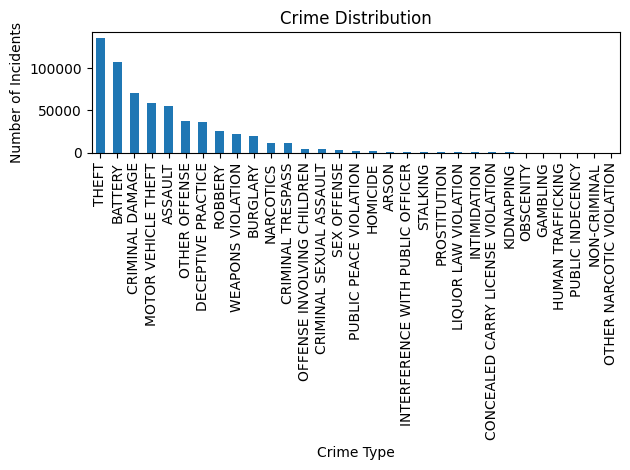

In [16]:
# 4. Visualization (Considering you will execute this in an environment supporting visualization like Jupyter)
import matplotlib.pyplot as plt

# Example visualization: Crime distribution
# Convert the Spark DataFrame to Pandas for visualization
crime_distribution_pd = crime_distribution.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
crime_distribution_pd.plot(kind='bar', x='Primary Type', y='count', legend=None)
plt.title('Crime Distribution')
plt.ylabel('Number of Incidents')
plt.xlabel('Crime Type')
plt.tight_layout()
plt.show()


In [17]:
# Analyze crime distribution
crime_distribution = combined_df.groupBy('Primary Type').count().orderBy('count', ascending=False)

# Weather impact on overall crime rates
weather_impact = combined_df.groupBy('date', 'temp', 'precip', 'humidity').count().orderBy('date')

# Analyze specific crime types vs. weather
specific_crime_weather = combined_df.filter(combined_df['Primary Type'] == 'THEFT').groupBy('date', 'temp').count().orderBy('date')

# Display the results
crime_distribution.show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|135721|
|             BATTERY|107345|
|     CRIMINAL DAMAGE| 71022|
| MOTOR VEHICLE THEFT| 58604|
|             ASSAULT| 54738|
|       OTHER OFFENSE| 37536|
|  DECEPTIVE PRACTICE| 36071|
|             ROBBERY| 25051|
|   WEAPONS VIOLATION| 21905|
|            BURGLARY| 19240|
|           NARCOTICS| 11210|
|   CRIMINAL TRESPASS| 10987|
|OFFENSE INVOLVING...|  4392|
|CRIMINAL SEXUAL A...|  3826|
|         SEX OFFENSE|  3041|
|PUBLIC PEACE VIOL...|  1920|
|            HOMICIDE|  1746|
|               ARSON|  1206|
|INTERFERENCE WITH...|  1186|
|            STALKING|  1137|
+--------------------+------+
only showing top 20 rows



In [18]:
weather_impact.show()

+----------+----+------+--------+-----+
|      date|temp|precip|humidity|count|
+----------+----+------+--------+-----+
|2021-08-06|76.6| 0.204|    61.5|  576|
|2021-08-07|78.4| 0.001|    69.0|  592|
|2021-08-08|80.9|  0.05|    65.5|  607|
|2021-08-09|75.9| 0.313|    78.6|  554|
|2021-08-10|81.8| 0.566|    74.5|  515|
|2021-08-11|80.4| 0.081|    72.7|  539|
|2021-08-12|78.8| 0.008|    71.0|  516|
|2021-08-13|75.9|   0.0|    57.0|  548|
|2021-08-14|72.9|   0.0|    48.2|  600|
|2021-08-15|71.5|   0.0|    53.9|  587|
|2021-08-16|72.6|   0.0|    56.0|  580|
|2021-08-17|75.4|   0.0|    67.5|  572|
|2021-08-18|78.5|   0.0|    72.9|  500|
|2021-08-19|79.1| 0.014|    72.0|  543|
|2021-08-20|80.7|   0.0|    66.9|  591|
|2021-08-21|79.9| 0.184|    70.5|  658|
|2021-08-22|76.2|   0.0|    67.5|  596|
|2021-08-23|78.2|   0.0|    66.9|  610|
|2021-08-24|82.2| 0.764|    70.7|  540|
|2021-08-25|79.7|  0.28|    72.4|  547|
+----------+----+------+--------+-----+
only showing top 20 rows



In [19]:
specific_crime_weather.show()

+----------+----+-----+
|      date|temp|count|
+----------+----+-----+
|2021-08-06|76.6|  106|
|2021-08-07|78.4|  126|
|2021-08-08|80.9|  103|
|2021-08-09|75.9|  113|
|2021-08-10|81.8|   94|
|2021-08-11|80.4|  116|
|2021-08-12|78.8|  115|
|2021-08-13|75.9|  124|
|2021-08-14|72.9|  117|
|2021-08-15|71.5|   98|
|2021-08-16|72.6|  119|
|2021-08-17|75.4|  110|
|2021-08-18|78.5|  108|
|2021-08-19|79.1|  132|
|2021-08-20|80.7|  142|
|2021-08-21|79.9|  140|
|2021-08-22|76.2|  132|
|2021-08-23|78.2|  121|
|2021-08-24|82.2|  119|
|2021-08-25|79.7|  130|
+----------+----+-----+
only showing top 20 rows

